In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm

from src.material_model import LinearElasticityLinearHardening as LELH
from src.sampler import MetropolisHastings, AdaptiveMetropolisHastings

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

save_figures = False

## Generic functions

In [2]:
def add_labels(graph_title, x_label, y_label, z_label):
    """
    Add labels to graphs
    """
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.set_zlabel(z_label)

## Papers

[Identifying elastoplastic parameters with Bayes’ theorem considering output error, input error and model uncertainty](https://www.sciencedirect.com/science/article/pii/S0266892018300547)

[A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://link.springer.com/article/10.1007/s11831-018-09311-x)

# Linear Elasticity-Linear Hardening

## Parameters

A linear elastic-linear hardening specimen is considered with Young's modulus $E =$ 210 GPa, yield stress $\sigma_{y0} =$ 0.25 GPa and plastic modulus $H$ = 50 GPa. 

The parameters to be identified (inferred) for the linear elastic-linear hardening model are the Young's modulus $E$, initial yield stress $\sigma_{y0}$ and the plastic modulus $H$, which are stored in the parameter vector $\textbf{x}$:

 $$\textbf{x}=[E \; \sigma_{y0} \; H]^T$$

In [3]:
E = 210           # Young's modulus (GPa)
stress_y = 0.25   # Yield stress (GPa)
H = 50            # Plastic modulus (GPa)
s_noise = 0.01    # Noise in the stress measurement (GPa)

## Constitutive model

The stress-strain response of the linear elastic-linear hardening model during monotonic tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = 
    \begin{cases}
        E\epsilon \quad \text{if} \quad \epsilon \leqslant \frac{\sigma_{y0}}{E} \\
        \sigma_{y0} + H\epsilon_p \quad \text{if} \quad \epsilon > \frac{\sigma_{y0}}{E}
    \end{cases}$$

Using the Heaviside step function $h$, the stress-strain response of the linear elastic-perfectly plastic model can alternatively be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) + \left(\sigma_{y0} + \frac{HE}{H + E}\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)$$

Where $\textbf{x}$ is the parameter vector:

$$\textbf{x} = [E \; \sigma_{y0} \; H]^T$$

$E$ is the Young's modulus, $\sigma_{y0}$ is the initial yield stress and $H$ is the plastic modulus.

### Stress-strain graph

Twelve experimental measurements are provided. The noise $\Omega$ in the stress measurements has a normal distribution with a zero mean and a standard deviation of $s_{noise}$.

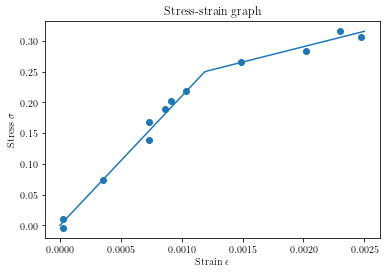

In [4]:
model = LELH(E, stress_y, H, s_noise)
strain = np.linspace(0, 2.5E-3, 100)
model.stress_strain_response(strain)
strain_data, stress_data = model.generate_synthetic_data(strain, 12, seed=12345)
plt.scatter(strain_data, stress_data);

## Likelihood $\pi(y|\textbf{x})$

The likelihood function for a single stress measurement is given by the following equation

$$\pi(y|\textbf{x}) = \pi_{noise}(y - \sigma(\epsilon, \textbf{x})) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - \sigma(\epsilon, \textbf{x})\right)^2}{2s^2_{noise}}}\right)$$

$$\pi(y|\textbf{x}) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) - \left(\sigma_{y0} + \frac{HE}{H + E}\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)$$

## Prior $\pi(\textbf{x})$

Choosing the prior distribution in the form of a modified normal distribution:

$$\pi(\textbf{x}) = exp\left(-\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} \right)$$

The following mean vector (prior candidate vector) and convariance matrix are selected:

$$\overline{\textbf{x}} = \begin{bmatrix} 200 \\ 0.29 \\ 60 \end{bmatrix} \; \text{GPa}, \quad \Gamma_\textbf{x} = \begin{bmatrix} 2500 & 0 & 0 \\ 0 & 2.7778 \times 10^{-4} & 0 \\ 0 & 0 & 100 \end{bmatrix} \; \text{GPa}^2$$

In [5]:
x_prior = np.array([[200], [0.29], [60]])                                    # Mean vector (GPa)
cov_matrix_prior = np.array([[2500, 0, 0], [0, 2.7778E-4, 0], [0, 0, 100]])  # Covariance matrix (GPa^2)
model.set_priors(x_prior, cov_matrix_prior)

## Posterior

The posterior distribution for a single stress measurement is given by the following equation:

$$\pi(\textbf{x}|y) \propto \pi(\textbf{x})\pi(y|\textbf{x}) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

If we now consider the posterior distribution of the previous measurement to be the prior distribution of the current measurement, the posterior for all $n_m$ measurements can be expressed as:

$$\pi(\textbf{x}|\textbf{y}) \propto \pi(\textbf{x})\pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x})) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\Sigma_{i=1}^{n_m}\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

Where $n_m$ is the number of measurements, $y_i$ is the measured stress and $\epsilon_i$ is the measured strain.

In [6]:
x_candidate = np.array([[210], [0.25], [50]])
print(model.posterior(strain_data, stress_data, x_candidate))

x_candidate = np.array([[200], [0.29], [60]])
print(model.posterior(strain_data, stress_data, x_candidate))

[[2.72357555e+15]]
[[92704.65969769]]


## Inference

In [7]:
data = [strain_data, stress_data]
mh = MetropolisHastings(model, data, n_samples=1E5, step_size=np.array([[5], [0.1], [1]]))

x_0 = np.array([[200], [0.29], [60]])  # Initial sample
x_hist, pdf_hist = mh.sample(x_0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3210.52it/s]


In [8]:
x_mean = mh.calculate_mean(x_hist)
print(x_mean)

[213.3552914    0.25492162  48.03665807]


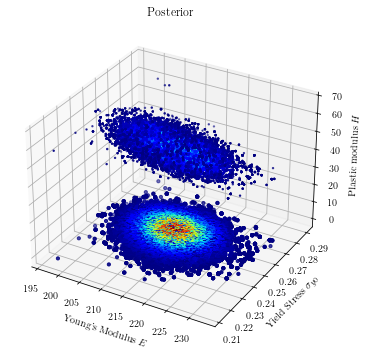

In [13]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_hist[:,0], x_hist[:,1], x_hist[:,2], s=2, c=pdf_hist, marker = 'o', cmap = cm.jet);

add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)", "Plastic modulus \(H\)")
plt.axvline(E, ls='--', color='dimgray')
plt.axhline(stress_y, ls='--', color='dimgray')

ax.scatter(x_hist[:,0], x_hist[:,1], s=10, c=pdf_hist, marker = 'o', cmap = cm.jet );

if save_figures:
    fig.savefig('LELH_posterior.png', dpi=300) 